In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Benchmark Data

In [2]:
benchmark_results_path = "../results/"
data = []
for root, dirs, files in os.walk(benchmark_results_path):
    for file in files:
        if file.endswith(".csv"):
            df_ = pd.read_csv(os.path.join(root, file))
            data.append(df_)

df = pd.concat(data)

### Aggregate Results for each Benchmark run

In [3]:
df['mean_reward'] = df.groupby(['model_name', 'env_id', 'sys_prompt', 'context_length'])['episode_reward'].transform('mean')
df['std_reward'] = df.groupby(['model_name', 'env_id', 'sys_prompt', 'context_length'])['episode_reward'].transform('std')
df['mean_length'] = df.groupby(['model_name', 'env_id', 'sys_prompt', 'context_length'])['episode_length'].transform('mean')
df['std_length'] = df.groupby(['model_name', 'env_id', 'sys_prompt', 'context_length'])['episode_length'].transform('std')

### Plot

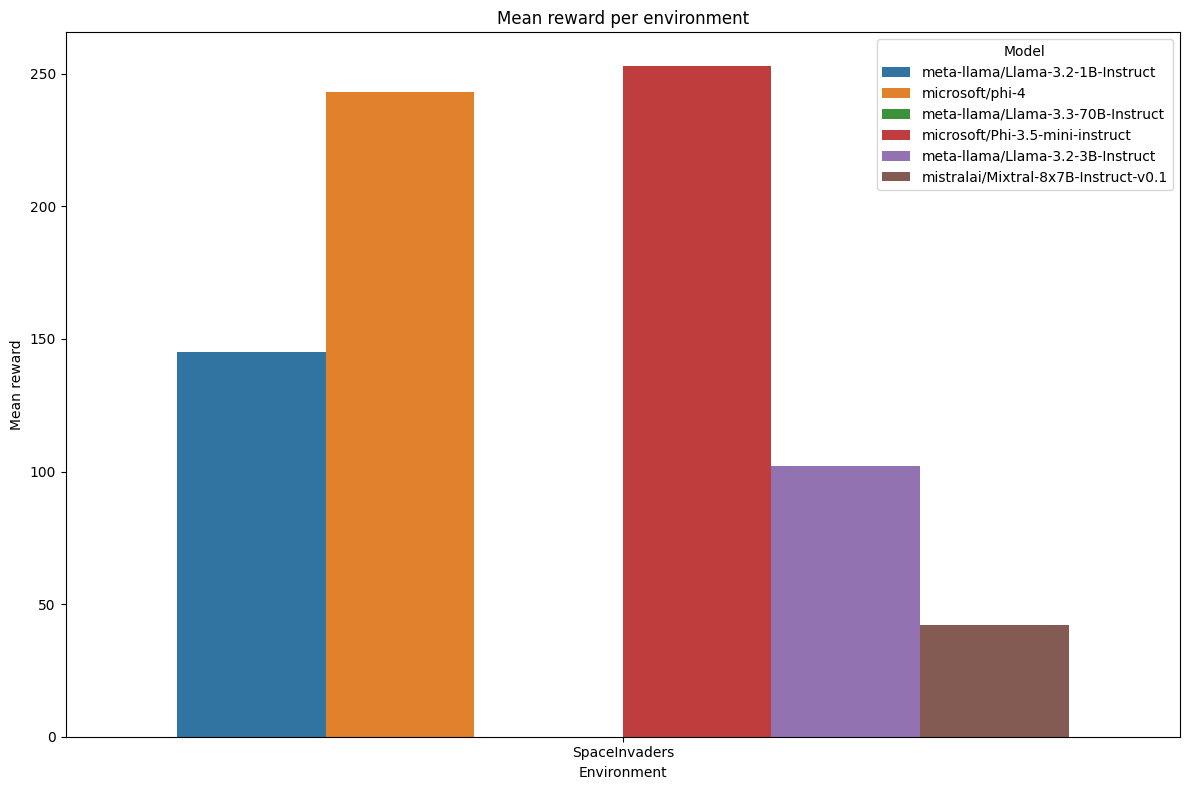

In [4]:
# plot the results (x axis each env, y axis mean reward, error bars std)
plt.figure(figsize=(12, 8))
sns.barplot(x='env_id', y='mean_reward', hue='model_name', data=df)
plt.title('Mean reward per environment')
plt.ylabel('Mean reward')
plt.xlabel('Environment')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('mean_reward_per_env.png')